# VGG19 model for TensorFlow

The architecture of VGG19.

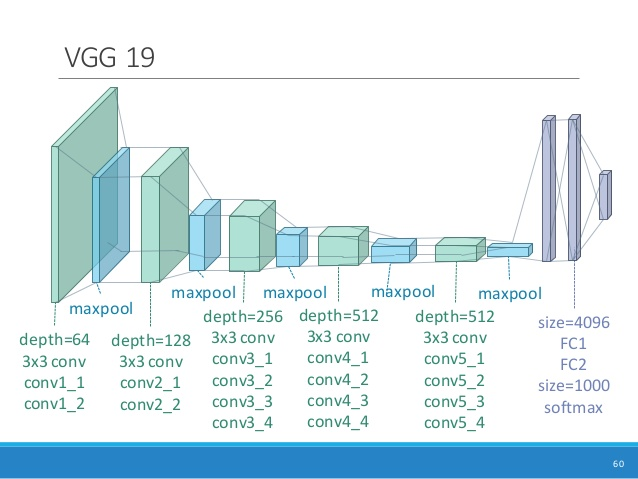
Photo credit: [here](https://www.google.com.tw/url?sa=i&rct=j&q=&esrc=s&source=images&cd=&cad=rja&uact=8&ved=0ahUKEwi8ht7aqePYAhXLn5QKHUBdCjoQjhwIBQ&url=https%3A%2F%2Fwww.slideshare.net%2Fckmarkohchang%2Fapplied-deep-learning-1103-convolutional-neural-networks&psig=AOvVaw1slTsE5aOOuBAQeTtZIY4m&ust=1516424783291429)

In [1]:
import pdb

import tensorflow as tf
import numpy as np
import scipy.io

In [2]:
# Define the mean pixel for image preprocessing
MEAN_PIXEL = np.array([ 123.68 ,  116.779,  103.939])

In [3]:
def net(data_path, input_image):
    '''
    Transfer the pre-trained VGG19 model (in .mat file) into
    TensorFlow's format.
    
    :param data_path:
        The path of VGG19 model.
        type: str
    :param input_image:
        A 4-D numpy array image.
        type: ndarray with float32
    :return:
        A VGG19 model with TensorFlow's format.
    '''
    # VGG19's architecture.
    layers = (
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

        'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
        'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

        'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
        'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

        'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
        'relu5_3', 'conv5_4', 'relu5_4')
    
    # Load the pre-trained VGG19 model
    data = scipy.io.loadmat(data_path)
    
    # The mean pixel of VGG19 is np.array([ 123.68 ,  116.779,  103.939])
    mean = data['normalization'][0][0][0]
    mean_pixel = np.mean(mean, axis=(0, 1))
    
    # The pre-trained weights.
    weights = data['layers'][0]

    net = {}
    current = input_image
    
    for i, name in enumerate(layers):
        # Select the kind of layers, such as conv, relu, pool.
        kind = name[:4]
        
        # If the layer is a Convolutional layer, rewrite it to 
        # the TensorFlow's format.
        if kind == 'conv':
            kernels, bias = weights[i][0][0][0][0]
            # matconvnet: weights are [width, height, in_channels, out_channels]
            # tensorflow: weights are [height, width, in_channels, out_channels]
            kernels = np.transpose(kernels, (1, 0, 2, 3))
            bias = bias.reshape(-1)
            
            # Rewrite to TensorFlow's format.
            current = _conv_layer(current, kernels, bias)
        
        # If the layer is a relu activation layer, rewrite it to 
        # the TensorFlow's format.
        elif kind == 'relu':
            current = tf.nn.relu(current)
        
        # If the layer is a pooling layer, rewrite it to the 
        # TensorFlow's format.
        elif kind == 'pool':
            current = _pool_layer(current)
        
        net[name] = current
    
    # Check the length of the net equals to layers.
    assert len(net) == len(layers)
    
    return net

In [4]:
def _conv_layer(input, weights, bias):
    '''
    Transfer convolutional layers to the format of TensorFlow.
    
    :param input:
        A 4-D numpy array image.
        type: ndarray with float32
    :param weights:
        The pre-trained model's weights.
    :param bias:
        The pre-trained model's bias.
    :return:
        A 4-D tensor has the same type as input.
        type: ndarray
    '''
    conv = tf.nn.conv2d(
        input, tf.constant(weights), strides=(1, 1, 1, 1), padding='SAME')
    
    return tf.nn.bias_add(conv, bias)


def _pool_layer(input):
    '''
    Transfer max pooling layers to the format of TensorFlow.
    
    :param input:
        A 4-D numpy array image.
        type: ndarray with float32
    :return:
        A 4-D tensor has the same type as input.
        type: ndarray
    '''
    max_pooling = tf.nn.max_pool(
        input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1), padding='SAME')
    
    return max_pooling


def preprocess(image):
    '''
    Minus the mean pixel. The mean pixel is calculated from VGG19 model.
    MEAN_PIXEL = np.array([123.68, 116.779, 103.939])
    
    :param image:
        A 3-D numpy array image.
        type: ndarray
    :return:
        The 3-D image minus MEAN_PIXEL
        type: ndarray
    '''
    return image - MEAN_PIXEL


def unprocess(image):
    '''
    Plus the mean pixel. The mean pixel is calculated from VGG19 model.
    MEAN_PIXEL = np.array([123.68, 116.779, 103.939])
    
    :param image:
        A 3-D numpy array image.
        type: ndarray
    :return:
        The 3-D image plus MEAN_PIXEL
        type: ndarray
    '''
    return image + MEAN_PIXEL